In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mutual_info_score

In [2]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [3]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [4]:
##Question 1


###1a
food_c = food.iloc[:,4:]
#typecasting all the values to float64 to avoid type warning from scaler
#astype returns copy
for i in range(len(food_c.keys().tolist())):
    food_c.iloc[:,i] = food_c.iloc[:,i].astype('float64')

###1b
scaler = StandardScaler(with_mean=True, with_std=True)
#creating ndarray with first column before appending all the values to it
scaled = scaler.fit_transform(food_c.iloc[:, 0].values[:,None].reshape(-1,1))
for i in range(1,53): 
    array = scaler.fit_transform(food_c.iloc[:, i].values[:,None].reshape(-1,1))
    scaled = np.append(scaled, array, axis = 1)
    
foodscaled = pd.DataFrame(scaled, columns=[i for i in food_c.dtypes.keys().tolist()])
mean = scaled.mean()
minn = scaled.min()
maxx = scaled.max()
std = scaled.std()
row = scaled.shape[0]
col = scaled.shape[1]
###1c
print(f"Rows: {row}\n"
        f"Columns: {col}\n"
        f"Min: {minn:.1f}\n"
        f"Max: {maxx:.1f}\n"
        f"Mean: {mean:.1f}\n"
        f"Stdev: {std:.1f}")

Rows: 5740
Columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Stdev: 1.0


Explained Variance:  [0.134789   0.11819063] 
Sum:  25.297963378429444 %


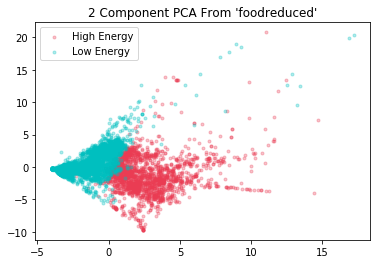

In [ ]:
#Question 2


###2a
foodscaled["EnergyLevel"] = np.where(food["Energy, with dietary fibre (kJ)"] > 1000, 1, 0)


###2b
pca = PCA(n_components = 2)
foodreduced = pca.fit_transform(foodscaled)
print("Explained Variance: ",pca.explained_variance_ratio_,
      "\nSum: ",sum(pca.explained_variance_ratio_)*100, '%')

###2c
index_h = foodscaled.index[foodscaled["EnergyLevel"] == 1].tolist()
index_l = foodscaled.index[foodscaled["EnergyLevel"] == 0].tolist()
plt.scatter([foodreduced[i][0] for i in index_h],[foodreduced[i][1] for i in index_h], 
            c = '#ea3c53', marker = '.', alpha = 0.3 , label = 'High Energy')
plt.scatter([foodreduced[i][0] for i in index_l],[foodreduced[i][1] for i in index_l], 
            c = 'c', marker = '.', alpha = 0.3, label = 'Low Energy')
plt.legend()
plt.title("2 Component PCA From 'foodreduced'")
plt.show()

Question 2d answer here:

From the graph it can be observed that the food are clustered together, however there is a clear seperation between low and high energy foods. PCA can be used to reduced dimentionality to speed up the calculation of the data in self learning algorithms by removing the features that do not provide much information. Using 2 component PCA on this data set is not wise as it loses much of its information through the dimensionality reduction, as only around 25% of the information is retained after the transformation.

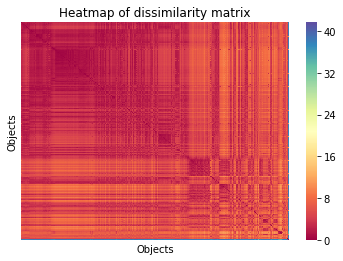

In [ ]:
#Question 3


###3a
food = food.astype({"Survey ID": str})
food["Food category"] = food['Survey ID'].str.slice(stop=2)
food["Food category"].astype("category")

###3b
foodscaledsample = foodscaled.loc[food["Food category"].isin(['13', '20', '24'])]

###3c
RV, C, I = VAT(foodscaledsample)


###3d
x = sns.heatmap(RV, cmap = 'Spectral', xticklabels=False, yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.title("Heatmap of dissimilarity matrix")
plt.show()


Question 3e here

    Two clear cluster can be seen from the colormap, this is an expected result as we divided the food intwo groups defined by their energy level. Different datasets would require different levels of contrast in order to best describe the dataset in 3D colourspace. A good colormap for this dataset would be a sequential type cmap, as the saturation and lightness change incrementally which would be able to represent ordered relationships in the data.

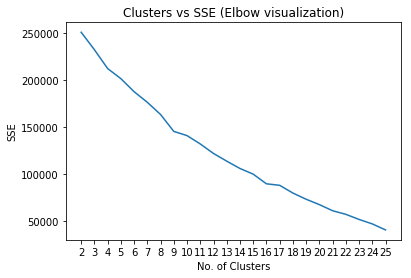

In [ ]:
#Question 4
###4a
sse = dict()
for k in range(2,26):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(foodscaled.T)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("No. of Clusters")
plt.ylabel("SSE")
plt.xticks(np.arange(2,26))
plt.title("Clusters vs SSE (Elbow visualization)")
plt.show()

Question 4b answer here
    The shape of this graph does not resemble the expected shape of a SSE vs k graph where the graph has a clear asymtote, it could be that k needs to be higher. The elbow is approximately at k = 14, this is not expected as I do not know enough about the data.

In [ ]:
food.head()

,Food ID,Survey ID,Food Name,Survey flag,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)",...,Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg),Food category
0,10F40019,31103001,"Beef, extract, bonox",NaN,401,401,56.6,16.6,0.2,6.5,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,31
1,13A12001,31302001,"Basil, dried",NaN,1079,774,10.0,18.2,5.5,15.5,...,1.40,0.61,0.26,0.34,0.0,0.0,0.0,0.0,0.0,31
2,10E10113,31302002,"Cardamom, seeds, ground",NaN,1333,1109,8.3,10.8,6.7,40.5,...,2.81,1.39,1.00,0.39,0.0,0.0,0.0,0.0,0.0,31
3,10E10098,31302003,Chilli (chili) powder,NaN,1441,1167,7.8,12.3,16.8,20.5,...,3.15,7.85,7.32,0.52,0.0,0.0,0.0,0.0,0.0,31
4,10E10107,31302004,"Chilli (chili), dried, ground",NaN,1573,1355,6.6,14.1,16.8,29.6,...,3.16,7.89,7.36,0.52,0.0,0.0,0.0,0.0,0.0,31


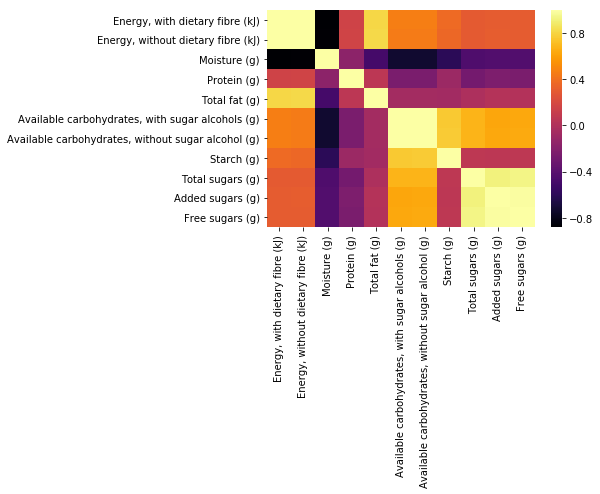

In [ ]:
###Question 5

###5a
matrix = food.iloc[:,4:15].corr(method = 'pearson')
sns.heatmap(matrix, cmap = 'inferno')


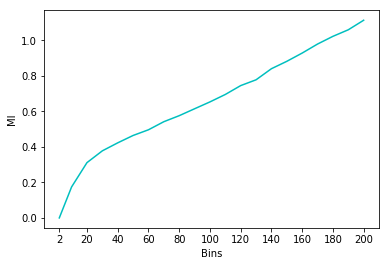

In [ ]:
###5b code
bins = [2]
bins.extend(range(10,201,10))
mi = []
for i in bins:
    matrix = np.histogram2d(food["Energy, with dietary fibre (kJ)"], food["Protein (g)"], i)[0]
    mi.append(mutual_info_score(None, None, contingency = matrix))
plt.plot(bins, mi, c = 'c')
plt.xlabel("Bins")
plt.ylabel("MI")
plt.xticks(bins[::2])
plt.show()

Question 5b comment here
    The plot suggests that the data has higher MI for higher amount of bins, this is expected, the graph increases rapidly at the start but slows down as the number of bins increase.

In [ ]:
###5c code
corr = food.corr(method = 'pearson').abs()
corr_top10 = (corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool)).stack().sort_values(ascending=False))[0:10]
#get rid of the reciprocating value
def mi_histogram(x, y ,bins):
    matrix = np.histogram2d(x, y, bins)[0]
    return (mutual_info_score(None, None, contingency = matrix))
mi = []
names = list(food)
for i in range(4,53):
    for j in range(4,53):
        mi.append([names[i], names[j], mi_histogram(food.iloc[:,i],food.iloc[:,j], 20)])
mi_sorted = sorted(mi, key = lambda x: x[2], reverse = True)
mi_top10 = []
for i in mi_sorted:
    if i[0] != i[1]:
        mi_top10.append(i)
    if len(mi_top10) == 20:
        break
mi_top10 = pd.DataFrame(mi_top10[::2], columns = ['x','y','mi'])

In [ ]:
print(mi_top10, '\n\n\n\n')
print(corr_top10)

Question 5c comment here
    The top 10 feature pairs sorted by MI values and Pearson correlations share some features, however the pearson correlation values include vitamins and fatty acids whilst the top 10 features sorted by MI only include macronutrients

In [ ]:
##Question 6
###6a
X_train, X_test, y_train, y_test = \
    train_test_split( foodscaled, food["Food category"], 
                     test_size= 1/4.0, random_state = 17)
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')
print(" X_train matrix:", X_train.shape, ' \n',
      "y_train labels:", y_train.shape, ' \n',
      "X_test matrix:", X_test.shape, ' \n',
      "y_test labels:", y_test.shape)
###6b


In [ ]:
def tree_depth(depth):
    """function for testing accuracy of the decision tree at different max dpeths"""
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train, y_train)
    return tree.score(X_test, y_test)
accuracy = []
depths = list(range(1,41))
for i in depths:
    accuracy.append(tree_depth(i+1))

In [ ]:
plt.plot(depths, accuracy, '-o', c = 'm')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()

Question 6c comment here

In [ ]:
#Question 7
def neighbors(k, part):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    score1 = knn.score(X_train, y_train)
    score2 = knn.score(X_test, y_test)
    print(f"""***\n
Q7{part}: Food category prediction using k-NN (k={k})\n
Train accuracy: {score1*100:.4}%\n
Test accuracy: {score2*100:.4}%\n
***\n""")
    return
###7a
neighbors(1, 'a')

##7b
neighbors(3, 'b')


Question 7c comment here
    
    The test accuracy was lower when k-neighbours increased, whilst the train accuracy remained at 100%, this was expected as the model was trained using the train set. The difference in test accuracy is due to the boundaries defined by KNN being smoother, ie. higher variance, however it also introduces bias to the prediction thus the training set accuracy was <100% for K = 3. Having a higher K value could make the model learn more about the overall distribution and be less affected by outliers, however in this dataset the lower K value produced a higher accuracy.
    
Question 7d comment here
    
    The standardisation was done column by column, this can be rectified by standardizing the whole dataframe at once. The model was overfit as the k value was very low, which increases the variance and lowers bias.

In [ ]:
#Question 8 code
#    tests the k-nn accuracy with 28 created features with n_neighbors = k
#    the KMeans cluster value is retrieved from the graph in Q4
#kmeans = KMeans(n_clusters = 14, random_state=0).fit(foodscaled)
def generate_features(x):
###randomly generating x new features from multiplying and x from dividing
    columns = [i[0:3] for i in list(foodscaled)]
    for i in range(x):
        q = np.random.randint(0, high = 53)
        p = np.random.randint(0, high = 53)
        xname = columns[p] + '*' + columns[q]
        yname = columns[p] + '/' + columns[q]
        foodscaled[xname] = foodscaled.iloc[:, p] * foodscaled.iloc[:, q]
        foodscaled[yname] = foodscaled.iloc[:, p] / foodscaled.iloc[:, q]
    return

###defining trainging/testing sets
generate_features(14)
X_train, X_test, y_train, y_test = \
    train_test_split( foodscaled, food["Food category"], 
                     test_size= 1/4.0, random_state = 17)
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

#making new features with KMeans clustering
kmeans = KMeans(n_clusters = 14, random_state=0).fit(X_train)
df = pd.DataFrame(X_train)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['km'] = kmeans.labels_
X_test['km'] = kmeans.predict(X_test)
##redefining KNN
def neighbors(k):
    """KNN with k neighbors, prints accuracy scores for 
    training and test sets
    Eg neighbours(k) >> Train accuracy: x%
                        Test accuracy: y%
    """
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    score1 = knn.score(X_train, y_train)
    score2 = knn.score(X_test, y_test)
    return (score1, score2)


In [ ]:
#TESTING
train_score = []
test_score = []
k = list(range(1,11,2))
for i in range(1,11,2):
    print(f"K = {i} \n Train: {neighbors(i)[0]} \n Test: {neighbors(i)[1]}\n")
    train_score.append(neighbors(i)[0])
    test_score.append(neighbors(i)[1])

plt.plot(k, train_score, '-o', c = 'm', label = 'train')
plt.plot(k, test_score, '-o', c = 'c', label = 'test')
plt.xlabel("Odd numbers of K")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Graph of K vs Accuracy for Increased Features")
plt.show()

Question 8 discussion here

    The addition of new features has decreased the accuracy of the model as compared to the results without the additional features, it could be that new variables that are randomly generated only contribute to the noise in the data, whilst it adds information , that information does not share variances with existing information. 
    In addtion, as mentioned before, increasing the value of K smoothens the boundaries of the selection and increases bias of the model.
    